In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import plot_roc_curve

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.decomposition import NMF, PCA

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (confusion_matrix, precision_score, 
                                    recall_score, accuracy_score, r2_score, 
                                    plot_confusion_matrix)

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, plot_confusion_matrix
from sklearn.cluster import DBSCAN

from sklearn import (
    cluster, decomposition, ensemble, manifold, 
    random_projection, preprocessing)
from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

# from sklearn.neighbors import KNeighborsRegressor

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import pickle
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV


## Functions

In [2]:
def plot_word_cloud(text, title, save_fig = False, f_name = None):
    wordcloud = WordCloud().generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")
    if save_fig:
        plt.savefig(f_name)
        
        
        

def plot_roc_curves_get_score_data(X_test, y_test, models, ax= plt):
    '''
    parameters:
    models is a list of sklearn models
    
    ax allows plotting on same ax
    
    returns:
    roc plot
    mse_scores 
    confusion_matrices 
    
    '''
    con_f = []
    acc_scores = []
    for model in models:
        y_pred = model.predict(X_test) 
        s = accuracy_score(y_test, y_pred)
        [[tn, fp], [fn, tp]] = confusion_matrix(y_test, y_pred)
        con_f.append([[tn, fp], [fn, tp]])
        acc_scores.append(s)
        plot_roc_curve(model, X_test, y_test, ax= ax)
        ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    
    return acc_scores, con_f


def get_feature_importance(fit_model):
    feature_importances = fit_model.feature_importances_
    return feature_importances

'''
specific code for "active" found below!
'''
# feature_importances = np.argsort(gb.feature_importances_)
# df.drop(['active'], axis = 1, inplace = True)
# features = df.columns[feature_importances]

# fig, axs = plt.subplots(figsize=(10,10))
def plot_partial_dep(X_train, feature_importances, features, model):
    plt.subplots_adjust(wspace=0.8, hspace=0.8,)
    plot_partial_dependence(model, X_train, feature_importances, ax = axs, feature_names = features)
#     plt.savefig('partial_dependence_plots.png')
    

def gridsearch_with_output(estimator, parameter_grid, X_train, y_train):
    '''
        Parameters: estimator: the type of model (e.g. RandomForestRegressor())
                    paramter_grid: dictionary defining the gridsearch parameters
                    X_train: 2d numpy array
                    y_train: 1d numpy array
        Returns:  best parameters and model fit with those parameters
    '''
    model_gridsearch = GridSearchCV(estimator,
                                    parameter_grid,
                                    n_jobs=-1,
                                    verbose=True,
                                    scoring='accuracy')
    model_gridsearch.fit(X_train, y_train)
    best_params = model_gridsearch.best_params_ 
    model_best = model_gridsearch.best_estimator_
    print("\nResult of gridsearch:")
    print("{0:<20s} | {1:<8s} | {2}".format("Parameter", "Optimal", "Gridsearch values"))
    print("-" * 55)
    for param, vals in parameter_grid.items():
        print("{0:<20s} | {1:<8s} | {2}".format(str(param), 
                                                str(best_params[param]),
                                                str(vals)))
    return best_params, model_best


### Sample DF

In [51]:
df = pd.read_csv('../../cleaned_comments.csv')

In [52]:
sample_df= df.sample(frac=1/2)


In [95]:
#Utilize 1/15 of data
# sample_df = pd.read_csv('../../sample_df.csv')

In [55]:
X = sample_df.text
y = sample_df.rating

In [56]:
 y.value_counts()[0]/(y.value_counts()[1] + y.value_counts()[0])

0.06696945606416596

### VECTORIZE AND VISUALIZE

In [41]:
snowball = SnowballStemmer(language = 'english')
port = PorterStemmer()
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english', analyzer='word', strip_accents='ascii',sublinear_tf = True)
txt_vect = vectorizer.fit_transform(X)
features = vectorizer.get_feature_names()

In [ ]:
# get indices of words with highest tfidf values

approved_features = txt_vect.toarray()[sample_df['rating']==0].mean(axis=0)
rejected_features = txt_vect.toarray()[sample_df['rating']==1].mean(axis=0)

approved_set = set(np.array(features)[approved_features.argsort()[::-1][:100]])
rejected_set = set(np.array(features)[rejected_features.argsort()[::-1][:100]])
approved_unique = approved_set.difference(rejected_set)
rejected_unique = rejected_set.difference(approved_set)

In [ ]:
plot_word_cloud(' '.join(approved_unique), title = 'Accepted Rating')
#                  save_fig=True, f_name = 'Accepted_wp.png')

In [ ]:
plot_word_cloud(' '.join(rejected_unique), title = 'Rejected Rating')
#                 save_fig=True, f_name = 'Rejected_wp.png')


## Imbalance fixed through undersampling

In [58]:
X_train, X_test, y_train, y_test = train_test_split(sample_df.text, sample_df.rating, stratify = sample_df.rating, test_size=0.1)
y_train.value_counts()
#Rejected values utilize only 7 percent of the overall available data


1    758406
0     54436
Name: rating, dtype: int64

In [59]:
train_df = pd.concat([X_train, y_train], axis = 1)
ap_df = train_df[train_df.rating ==1]
rej_df = train_df[train_df.rating == 0]
#check your work
ap_df.rating.value_counts(), rej_df.rating.value_counts()

(1    758406
 Name: rating, dtype: int64,
 0    54436
 Name: rating, dtype: int64)

In [61]:
min_val = rej_df.rating.value_counts()[0]
min_val

54436

In [62]:
#try to undersampling the majority class?

r = np.random.RandomState(42)
inds = np.arange(min_val)
r.shuffle(inds)
#put indices in a random order for selection

In [63]:
rej_df1=rej_df.iloc[inds]
ap_df1=ap_df.iloc[inds]


In [64]:
fixed_train_df = pd.concat([rej_df1, ap_df1], axis = 0)

In [65]:
shuffled_df = fixed_train_df.sample(frac=1)

In [66]:
shuffled_df.rating.value_counts()

1    54436
0    54436
Name: rating, dtype: int64

In [67]:
X_train = shuffled_df.text.values
y_train = shuffled_df.rating.values

In [68]:
shuffled_df.rating.value_counts()

1    54436
0    54436
Name: rating, dtype: int64

## Train Test Split with Vectorizing 

In [200]:
# X_train, X_test, y_train, y_test = train_test_split(sample_df.text, sample_df.rating, stratify = sample_df.rating, test_size=0.2)

In [69]:
snowball = SnowballStemmer(language = 'english')
port = PorterStemmer()
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english', analyzer='word', strip_accents='ascii',sublinear_tf = True)
x_train_vect = vectorizer.fit_transform(X_train)
features = vectorizer.get_feature_names()

#### Only transform your test set on your vectorizer

In [70]:
x_test_vect = vectorizer.transform(X_test.values)

## Random Forest with Balanced Classes
x_train_vect, x_test_vect, y_train, y_test

In [71]:
model = RandomForestClassifier(n_jobs=-1, 
                               random_state  = 1,
                               max_depth = 4, 
                               n_estimators=500, 
                              max_features = 500, 
                              min_samples_split = 2,
                              bootstrap = True,
                              min_samples_leaf = 1)
model.fit(x_train_vect, y_train)

# max_depth            | 4        | [3, 2, 4]
# min_samples_split    | 2        | [2, 4]
# min_samples_leaf     | 1        | [1, 2, 4]
# bootstrap            | True     | [True, False]

RandomForestClassifier(max_depth=4, max_features=500, n_estimators=500,
                       n_jobs=-1, random_state=1)

In [72]:
y_pred = model.predict(x_test_vect)

accuracy_score(y_test, y_pred), \
    precision_score(y_test, y_pred), \
           recall_score(y_test, y_pred)




(0.8952787988839187, 0.9390361276086293, 0.9493995348174871)

b4 GB: (0.8306501616546348, 0.9444945499523282, 0.8696570296465899)
aftter GB: (0.8317463129456575, 0.9446224727488, 0.8707721874888781) 
(0.8952787988839187, 0.9390361276086293, 0.9493995348174871)

In [76]:
rftn, rffp, rffn, rftp = confusion_matrix(y_test, y_pred).ravel()
rftn, rffp, rffn, rftp

(854, 5194, 4264, 80004)

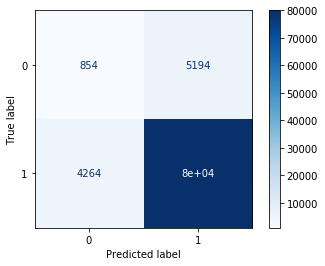

In [77]:
plot_confusion_matrix(model,x_test_vect, y_test, cmap = plt.cm.Blues)
plt.savefig('rf_con_mx.png')

In [103]:
# save the model to disk
# filename = 'balanced_rf_model.sav'
# pickle.dump(model, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
# print(result)

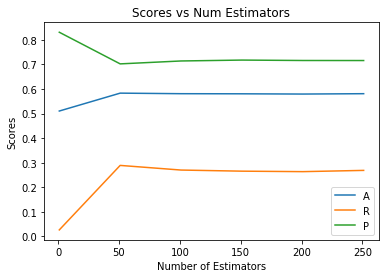

In [44]:
n_ests= np.arange(1, 300, 50)
accuracies = []
recall = []
precision = []

for n in n_ests:
    
    model = RandomForestClassifier(n_jobs=-1, 
                               random_state  = 3,
                               max_depth = 3, 
                               n_estimators=n, 
                              max_features = 60, 
                                  )
        
    model.fit(x_train_vect, y_train)
    y_pred = model.predict(x_train_vect)
    accuracies.append(accuracy_score(y_train, y_pred))
    recall.append(recall_score(y_train, y_pred))
    precision.append(precision_score(y_train, y_pred))

fig, ax = plt.subplots()
ax.plot(n_ests, accuracies, label = 'A')
ax.plot(n_ests, recall, label = 'R')
ax.plot(n_ests, precision, label = 'P')
ax.set_xlabel("Number of Estimators")
ax.set_ylabel("Scores")
ax.set_title('Scores vs Num Estimators')
# plt.savefig('RF_acur_v_feat.png')
plt.legend()
plt.show()


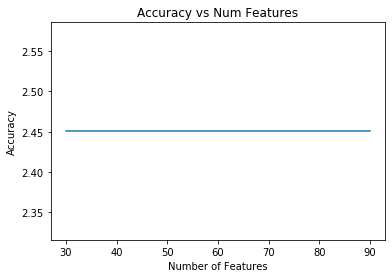

In [148]:
# num_features = np.arange(30, 100, 10)
# accuracies = []

# for n in num_features:
#     tot = 0
#     for i in range(5):
#         model = RandomForestClassifier(n_jobs=-1, 
#                                random_state  = 1,
#                                max_depth = 4, 
#                                n_estimators=500, 
#                               max_features = n)
        
#         model.fit(x_train_vect, y_train)
#         y_pred = model.predict(x_test_vect)
#         tot += accuracy_score(y_test, y_pred)
#     accuracies.append(tot)
# fig, ax = plt.subplots()
# ax.plot(num_features, accuracies)
# ax.plot
# ax.set_xlabel("Number of Features")
# ax.set_ylabel("Accuracy")
# ax.set_title('Accuracy vs Num Features')
# # plt.savefig('RF_acur_v_feat.png')
# plt.show()

## Bernoulli Naive Bayes with Balanced Classes
x_train_vect, x_test_vect, y_train, y_test

In [114]:
nb = BernoulliNB()
nb.fit(x_train_vect, y_train)

BernoulliNB()

In [115]:
y_pred = nb.predict(x_test_vect)

In [116]:
accuracy_score(y_test, y_pred), \
    precision_score(y_test, y_pred), \
           recall_score(y_test, y_pred)


(0.49688870189113776, 0.9636298507462686, 0.47885318270280536)

In [117]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(4525, 1523, 43916, 40352)

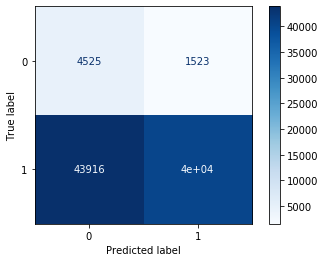

In [118]:
plot_confusion_matrix(nb,x_test_vect, y_test, cmap = plt.cm.Blues)

Way better at predicting positives than positives 

## ComplementNB

In [119]:
from sklearn.naive_bayes import ComplementNB

In [120]:
cnb = ComplementNB()
cnb.fit(x_train_vect, y_train)
y_pred = cnb.predict(x_test_vect)

In [121]:
accuracy_score(y_test, y_pred), \
    precision_score(y_test, y_pred), \
           recall_score(y_test, y_pred)


(0.6423225120687365, 0.9615411944434575, 0.642343475577918)

In [123]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(3883, 2165, 30139, 54129)

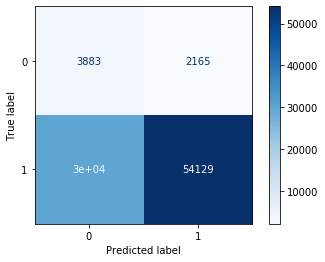

In [125]:
plot_confusion_matrix(cnb,x_test_vect, y_test, cmap = plt.cm.Blues)

## Gradient Boosted Classifier Search

In [126]:
gb = GradientBoostingClassifier(n_estimators = 500, learning_rate = 0.01, random_state=0)
gb.fit(x_train_vect, y_train)


GradientBoostingClassifier(learning_rate=0.01, n_estimators=500, random_state=0)

In [127]:
y_pred = gb.predict(x_test_vect)

accuracy_score(y_test, y_pred), \
    precision_score(y_test, y_pred), \
           recall_score(y_test, y_pred)

(0.8157912219318836, 0.9461677507883521, 0.8509873261499027)

(1968, 4080, 12557, 71711)

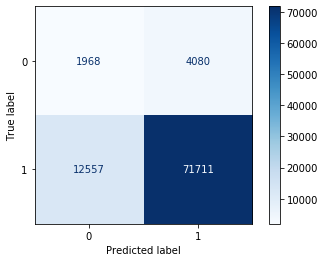

In [128]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

plot_confusion_matrix(gb,x_test_vect, y_test, cmap = plt.cm.Blues)

tn, fp, fn, tp

lr 0.1: (0.6365428052615262, 0.9618276771773658, 0.6358060574424923)

lr 0.01: (0.8213937729748881, 0.9464234264910029, 0.8571886083006156)

## GRIDSEARCHCV

In [79]:
#RandomForest

rf_gs = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=3, max_features = 60)

random_forest_grid = {'max_depth': [3, 2, 4],
                      'min_samples_split': [2, 4],
                      'min_samples_leaf': [1, 2, 4],
                      'bootstrap': [True, False]}
rf_best_params, rf_best_model = gridsearch_with_output(rf_gs, 
                                                       random_forest_grid, 
                                                       x_train_vect, y_train)

# gridsearch_with_output(estimator, parameter_grid, X_train, y_train):
    

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.5min finished



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
max_depth            | 4        | [3, 2, 4]
min_samples_split    | 2        | [2, 4]
min_samples_leaf     | 1        | [1, 2, 4]
bootstrap            | True     | [True, False]


In [20]:
gb_gs = GradientBoostingClassifier(n_estimators = 500, random_state=0, learning_rate = 0.01)

gradient_boost_grid = {'warm_start':[True, False],
                        'loss' :['exponential', 'deviance'],
                      'subsample' :[1.0, 0.8, 0.5],
                      'criterion' :['friedman_mse', 'mse', 'mae'],
                     'min_impurity_decrease': [0, 0.05, 0.1]}


gb_best_params, gb_best_model = gridsearch_with_output(gb_gs, 
                                                       gradient_boost_grid, 
                                                       x_train_vect, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KeyboardInterrupt: 

In [113]:
# nb = BernoulliNB(alpha = 3)

bnb_gs = BernoulliNB()

gradient_boost_grid = {'alpha':[1, 3, 5, 20]}


bnb_best_params, bnb_best_model = gridsearch_with_output(bnb_gs, 
                                                       gradient_boost_grid, 
                                                       x_train_vect, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
alpha                | 1        | [1, 3, 5, 20]


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.5s finished


## Cross Valedate Test

In [123]:
sk_train_neg_rmses = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error')
sk_train_rmse = np.mean(sk_train_neg_rmses)*(-1)

In [125]:
sk_test_neg_rmses = cross_val_score(model, X_test, y_test, scoring='neg_root_mean_squared_error')
sk_test_rmse = np.mean(sk_test_neg_rmses)*(-1)

In [126]:
print(f'Sklearn train RMSE: {sk_train_rmse:0.03f}')
print(f'Sklearn test RMSE: {sk_test_rmse:0.03f}')

Sklearn train RMSE: 0.149
Sklearn test RMSE: 0.150


In [ ]:
def plot_error_vs_splitsize(X_train, y_train, n_obs_arr):
    cv_train_errors = []
    cv_test_errors = []
    for n_obs in n_obs_arr.astype('int'):
        train_error = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error')

        test_error = cross_val_score(model, X_test, y_test, scoring='neg_root_mean_squared_error')
        cv_train_errors.append(np.mean(train_error)*-1)
        cv_test_errors.append(np.mean(test_error)*-1)
    
    plt.close('all')
    
    fig, ax = plt.subplots()
    ax.plot(n_obs_arr, cv_train_errors, label='Train')
    ax.plot(n_obs_arr, cv_test_errors, label='Test')
    ax.set_xlabel('Training set size')
    ax.set_ylabel('RMSE')
    ax.legend()
    plt.show()

    
    
train_lens = np.linspace(10,100, 25)
plot_error_vs_splitsize(X_train, y_train, n_obs_arr=train_lens )


In [ ]:
tn, fp, fn, tp = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()
# (tn, fp, fn, tp)
# (0, 2, 1, 1)

## PLOT ROC CURVES ALL MODELS

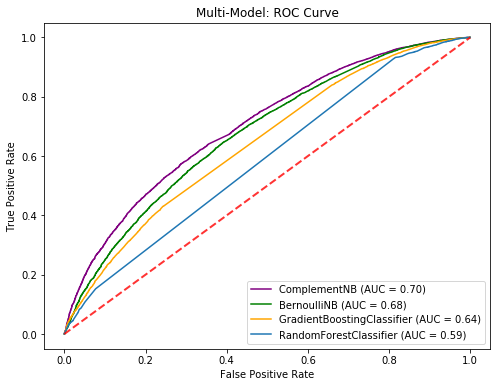

In [132]:
fig, ax = plt.subplots(1, figsize = (8,6))
plot_roc_curve(cnb, x_test_vect, y_test, ax = ax, color = 'purple')
plot_roc_curve(nb, x_test_vect, y_test, ax = ax, color = 'g')
plot_roc_curve(gb, x_test_vect, y_test, ax = ax, color = 'orange')
plot_roc_curve(model, x_test_vect, y_test, ax = ax)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.title('Multi-Model: ROC Curve')
plt.savefig('ROC_multi.png')
plt.show()

## PLOT PRECISION RECALL CURVES

Text(0.5, 1.0, '2-class Precision-Recall curve')

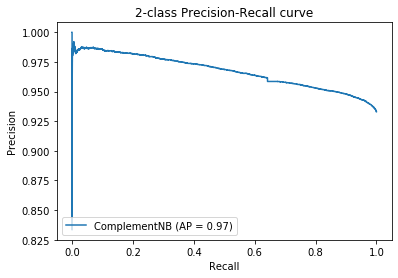

In [131]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

disp = plot_precision_recall_curve(cnb, x_test_vect, y_test)
disp.ax_.set_title('2-class Precision-Recall curve')